# 7.1 Monte Carlo for integrals

In [2]:
# The usual notebook preferences
%config InlineBackend.figure_format = 'svg'
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from helper_functions import *
set_notebook_preferences()

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Let's start off with a simple example which gives good insight on the main idea behind MC. Suppose we want to approximate the number $\pi$ to some number of decimal places. The analytic approach would be to use an infinite series involving $\pi$ and use it to make an approximation. MC offers a very simple and elegant alternative, its elegance rooted in the fact that we need not prove anything about infinite series to make the approximation.

Imagine selecting a point $(x, y)$ at random, meaning uniformly distributed, within a unit square centered at the origin. If the point lies within the unit circle, $r^2 = x^2 + y^2 < 1$, count the sample as a success and reject it otherwise, repeating the process $N$ times to get a success count $N_s$. Because each point is uniformly distributed within the unit square, of area $1$, and the unit-diameter circle occupies an area $\pi/4$ of that, the success freaction $N_s/N$ will approach $\pi/4$ for large $N$, which we can rearrange to obtain the approximation $\pi \approx 4N_s/N$.

In [4]:
N = 10**4 # number of samples

samples = np.random.rand(N, 2) - 0.5 # draw uniformly distributed samples from unit square
radii = np.sum(samples**2, axis = 1)**0.5 # compute radii of each point from origin
N_s = np.where(radii < 1/2)[0] # number of successes

pi_approx = 4*len(N_s)/N # our approximation of pi by ratios of areas
print("Estimate of pi:", pi_approx, "error absolute value:", np.abs(pi_approx - np.pi).round(3))

Estimate of pi: 3.15 error absolute value: 0.008


This gives a reasonable estimate for $\pi$. How does the error magnitude depend on the number of samples? You can experiment with ```N``` to see its effect. We will shortly answer this question in detail, but for the moment let's have a look at the following illustration:

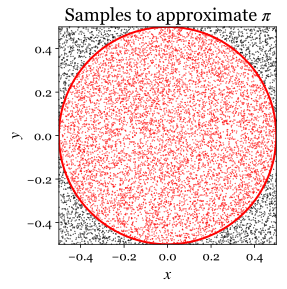

In [5]:
colors = np.array(['black', 'red'])[(radii <= 1/2)*1]
plt.scatter(samples[:, 0], samples[:, 1], s = 0.1, color = colors)
plt.gca().add_artist(plt.Circle((0, 0), 1/2, color = 'red', fill = False, linewidth = 2))
plt.xlim([-0.5, 0.5]), plt.ylim([-0.5, 0.5])
plt.gca().set_aspect('equal')
beautify_plot({"title": "Samples to approximate $\pi$","x":"$x$", "y":"$y$"})
plt.show()

In this plot, each red point is counted as a success, black points are the rejected points, and the total number of red and black points is equal to $N$. The approximation for $\pi$ is then

$$\pi \approx 4 \times\frac{\color{red}{\text{Successes}}}{\color{red}{\text{Successes}} + \text{Rejections}}$$

Note that the only piece of knowledge used here is the area of the circle, $\pi r^2$. This approach seems to have worked reasonably well for $\pi$. Can we extend the same idea on other tasks such as the difficult integral we talked about earlier

\begin{align}
A = \int_{-\infty}^{\infty} f(x) dx = \int_{-\infty}^{\infty} e^{-\frac{1}{10}x^4 - \frac{1}{10}x^3 - \frac{1}{2}x^2} dx
\end{align}

Following the same argument applied to $\pi$, we can then approximate the area under the curve as follows. Because the integrand's tails go to $0$ very rapidly, cutting them off is a good approximation:

\begin{align}
A \approx \int_{x_{min}}^{x_{max}} e^{-\frac{1}{10}x^4 - \frac{1}{10}x^3 - \frac{1}{2}x^2} dx = \int_{-4}^{4} e^{-\frac{1}{10}x^4 - \frac{1}{10}x^3 - \frac{1}{2}x^2} dx
\end{align}

The definite integral can in turn be approximated using the same MC method as for $\pi$, by sampling uniformly distributed points from the rectangle $(x_{min}, x_{max}), (y_{min}, y_{max})$, of area $A_R$ and counting the number of them which have $y < f(x)$ as illustrated:

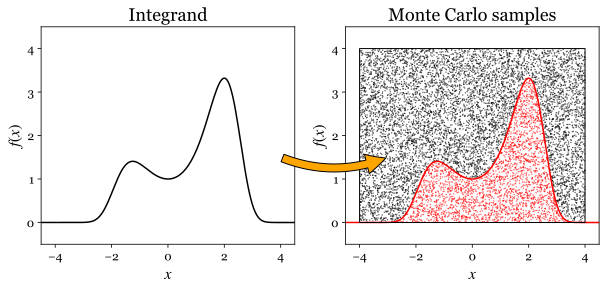

In [13]:
max_x, min_x, max_y, min_y = 4, -4, 4, 0

fig = plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
x = np.linspace(-5, 5, 200)
y = np.exp(-(0.1*x**4 - 0.1*x**3 - 0.5*x**2))

plt.plot(x, y, color = 'black')
beautify_plot({'title':'Integrand', "x":"$x$", "y":"$f(x)$"})
plt.xlim([min_x-0.5, max_x+0.5]), plt.ylim([min_y-0.5, max_y+0.5])
ax_0 = plt.gca()

plt.subplot(1, 2, 2)
no_samples = 10**4

samples = np.random.uniform([min_x, min_y], [max_x, max_y], (no_samples, 2))

x_ = samples[:, 0]
y_ = np.exp(-(0.1*x_**4 - 0.1*x_**3 - 0.5*x_**2))
counts = len(np.where(samples[:, 1] <= y_)[0])

area = (max_x - min_x)*(max_y - min_y)

colors = np.array(['black', 'red'])[(samples[:, 1] <= y_)*1]
plt.scatter(samples[:, 0], samples[:, 1], s = 0.1, color = colors)
plt.plot(x, y, color = 'red')
plt.xlim([min_x-0.5, max_x+0.5]), plt.ylim([min_y-0.5, max_y+0.5])
beautify_plot({"title": "Monte Carlo samples", "x":"$x$", "y":"$f(x)$"})
ax_1 = plt.gca()

ax0tr = ax_0.transData # Axis 0 -> Display
ax1tr = ax_1.transData # Axis 1 -> Display
figtr = fig.transFigure.inverted() # Display -> Figure
# 2. Transform arrow start point from axis 0 to figure coordinates
ptB = figtr.transform(ax0tr.transform((4, 1.5)))
# 3. Transform arrow end point from axis 1 to figure coordinates
ptE = figtr.transform(ax1tr.transform((-3, 1.5)))
# 4. Create the patch
arrow = matplotlib.patches.FancyArrowPatch(
    ptB, ptE, transform=fig.transFigure,  # Place arrow in figure coord system
    fc = "orange", connectionstyle="arc3,rad=0.2", arrowstyle='simple', alpha = 1,
    mutation_scale = 40.)
# 5. Add patch to list of objects to draw onto the figure

fig.patches.append(arrow)

rect = patches.Rectangle((-4, 0), 8, 4, linewidth = 1, edgecolor='black', facecolor='none', zorder = 5)
plt.gca().add_patch(rect)

plt.show()

We can then use the proportionality between the areas $A, A_R$ and respective counts $N_s, N$ to obtain:

\begin{align}
\frac{\color{red}{\text{Area under red curve, }A}}{\text{Black rectangle area, }A_R} &\approx \frac{\color{red}{N_s}}{N}\\
~\\
\end{align}
\begin{align}
\color{red}{A} &\approx A_R\times\frac{\color{red}{N_s}}{N}\\
\end{align}

Let's see what an implementation of this method might look like:

MC value of integral: 8.272


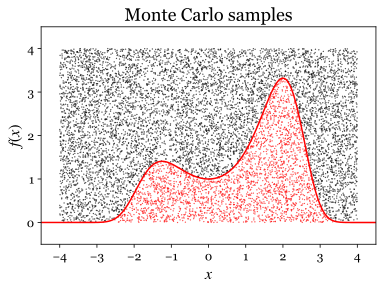

In [20]:
N = 10**4 # number of samples for MC approximation
max_x, min_x, max_y, min_y = 4, -4, 4, 0 # coordinates of black rectangle
area = (max_x - min_x)*(max_y - min_y) # rectangle area

samples = np.random.uniform([min_x, min_y], [max_x, max_y], (N, 2)) # draw N samples in the box
x_ = samples[:, 0] # first column of (N, 2) sample matrix is x coordinate
y_ = np.exp(-(0.1*x_**4 - 0.1*x_**3 - 0.5*x_**2)) # integrand formula gives y
N_s = len(np.where(samples[:, 1] <= y_)[0]) # number of successes 

print("MC value of integral:", area*N_s/N)

colors = np.array(['black', 'red'])[(samples[:, 1] <= y_)*1]
plt.scatter(samples[:, 0], samples[:, 1], s = 0.1, color = colors)
plt.plot(x, y, color = 'red')
plt.xlim([min_x-0.5, max_x+0.5]), plt.ylim([min_y-0.5, max_y+0.5])
beautify_plot({"title": "Monte Carlo samples", "x":"$x$", "y":"$f(x)$"})

plt.show()

How can we estimate the random error in this estimate and how does this depend on the number of samples? One method is to repeat the MC estimate several times, and use the spread of these estimates as an error estimate, and their mean as our final answer. We can find the dependence of the error on $N$ by repeating for different values of $N$:

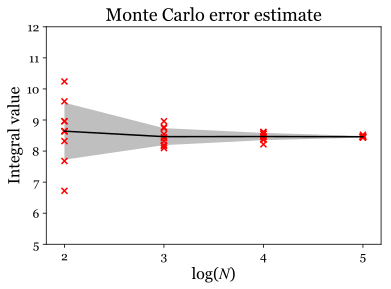

In [8]:
sample_sizes = np.array([10**2, 10**3, 10**4, 10**5]) # number of samples N to try out
trials_per_size = 10 # number of MC trials for each sample size

estimates = []
for N in sample_sizes:
    
    estimates.append([])
    for i in range(trials_per_size):
        
        # same approach as before for the MC estimate
        samples = np.random.uniform([min_x, min_y], [max_x, max_y], (N, 2))
        x_ = samples[:, 0]
        y_ = np.exp(-(0.1*x_**4 - 0.1*x_**3 - 0.5*x_**2))
        N_s = len(np.where(samples[:, 1] <= y_)[0])
        estimates[-1].append(area*N_s/N)
    
estimates = np.array(estimates)
means, stdevs = estimates.mean(axis = 1), estimates.var(axis = 1)**0.5
plt.plot(np.log10(sample_sizes), means, color = 'black')
plt.fill_between(np.log10(sample_sizes), means + stdevs, means - stdevs, facecolor = 'grey', alpha = 0.5)
plt.scatter((np.array([np.log10(sample_sizes)]*trials_per_size).T).flatten(),
            estimates.flatten(), marker = 'x', color = 'red')
beautify_plot({"title": "Monte Carlo error estimate", "x":"log($N$)", "y":"Integral value"})
plt.xticks(np.arange(2, 6)), plt.yticks(np.arange(5, 13))
plt.show()

The red crosses respresent individual MC estimates. For each value of $N$, we have made $10$ such estimates, and calculated their mean (black line) and standard deviation (gray area). As $N$ increases, the spread in the estimates decreases and our approximation becomes progressively more confident. What is the precise mathematical dependence of the statistical error of a single MC estimate on $N$? Denoting the MC estimate of the integral $\hat{A}$, it can be shown that $-$ you can try this as an excercise:

\begin{align}
\mathbb{E}(\hat{A}) &= A\\
~\\
E_{rms}(\hat{A}) &\equiv \mathbb{E}\big[(\hat{A} - \mathbb{E}(\hat{A}))^2\big] = \mathcal{O}(N^{-0.5})
\end{align}

<details>
<summary>RMS error in detail</summary>
<div>

Here give an outline of a proof of $\mathbb{E}(\hat{A}) = A$ and $E_{rms}(\hat{A}) = \mathcal{O}(N^{-0.5})$. This proof is for the example above, but you will see that it can easily be extended to more general cases. Suppose we make $N$ samples in a uniform rectangle as described above. The probability, $p$, that each of these samples falls under the curve is the fraction of the area under the curve, $A$, to the total area of the rectangle, say $A_R$. Since the samples are independent, the number of samples under the curve, $N_s$, is binomially distributed. For this binomial distribution:

\begin{align}
\mathbb{E}(N_s) &= Np\\
~\\
\text{Var}(N_s) &= Np(1-p)\\
\end{align}

Our estimate for the area under the curve is then

\begin{align}
\hat{A} &= A_R\frac{N_s}{N}\\
~\\
\mathbb{E}(\hat{A}) &= A_R\mathbb{E}\bigg(\frac{N_s}{N}\bigg)\\
~\\
\mathbb{E}(\hat{A}) &= A_Rp\\
~\\
\mathbb{E}(\hat{A}) &= A\\
\end{align}

Where in the last line we used $p = A/A_R$. For the variance we have:

\begin{align}
\text{Var}(\hat{A}) &= \mathbb{E}\big[(\hat{A} - \mathbb{E}(\hat{A}))^2\big]\\
~\\
&= \mathbb{E}[(A_RN_s/N)^2] - \mathbb{E}[A_RN_s/N]^2\\
~\\
&= \frac{A_R^2}{N^2}\big[\mathbb{E}[N_s^2] - \mathbb{E}[N_s]^2\big]\\
~\\
&= \frac{A_R^2}{N^2}\text{Var}(N_s)\\
~\\
&= \frac{A_R^2}{N}p(1-p)\\
\end{align}

Noting that $ E_{rms}(\hat{A}) = \sqrt{\text{Var}(\hat{A})}$:

\begin{align}
E_{rms}(\hat{A}) \propto N^{-0.5} \implies E_{rms}(\hat{A}) = \mathcal{O}(N^{-0.5})
\end{align}

as required. Evindently, we can extend this method to other integrands and also higher dimensional integrals.

</div>
</details>

Let's put the RMS error formula to the test for the example of $\pi$: a log-log plot of the RMS error against the number of samples should be a straight line with a slope of $-0.5$. We will make several MC estimates for each of several different values of $N$ and plot the log-log plot of the results.

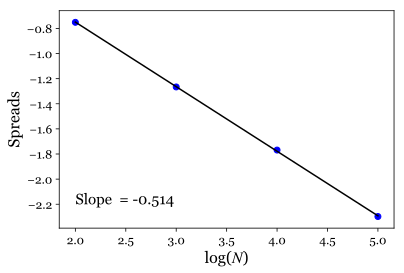

In [9]:
sample_sizes = np.array([10**2, 10**3, 10**4, 10**5]) # number of samples N to try out
trials_per_size = 100 # number of MC trials for each sample size

estimates = []
for N in sample_sizes:
    
    estimates.append([])
    for i in range(trials_per_size):
        
        samples = np.random.rand(N, 2) - 0.5
        radii = np.sum(samples**2, axis = 1)**0.5
        N_s = np.where(radii < 1/2)[0]

        estimates[-1].append(4*len(N_s)/N - np.pi)
        
stdevs = np.var(np.array(estimates), axis = 1)**0.5
plt.scatter(np.log10(sample_sizes), np.log10(stdevs), marker = 'o', color = 'blue')
beautify_plot({"title": "", "x":"log($N$)", "y":"Spreads"})
slope, intercept = stats.linregress(np.log10(sample_sizes), np.log10(stdevs))[:2]
plt.plot(np.linspace(2, 5, 100), slope*np.linspace(2, 5, 100) + intercept, color = 'black')
plt.text(2, -2.2, s = 'Slope  = {}'.format(slope.round(3)), fontsize = 15)
plt.show()

Here, we have denoted  the blue points are the $E_{rms}$ errors of the MC estimate for each value of $N$. The slope of the trendline is very close to the expected $-0.5$ confirming the dependence $E_{rms}(\hat{A}) = \mathcal{O}(N^{-0.5})$. We can repeat the same process for the integral $A$:

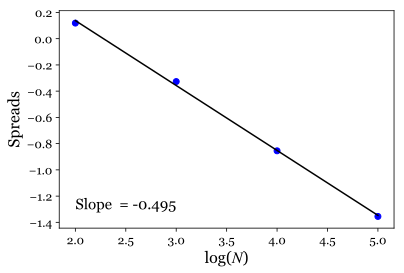

In [10]:
sample_sizes = np.array([10**2, 10**3, 10**4, 10**5]) # number of samples N to try out
trials_per_size = 100 # number of MC trials for each sample size

estimates = []
for N in sample_sizes:
    
    estimates.append([])
    for i in range(trials_per_size):
        
        samples = np.random.uniform([min_x, min_y], [max_x, max_y], (N, 2)) # draw N samples in the box
        x_ = samples[:, 0] # first column of (N, 2) sample matrix is x coordinate
        y_ = np.exp(-(0.1*x_**4 - 0.1*x_**3 - 0.5*x_**2)) # integrand formula gives y
        N_s = len(np.where(samples[:, 1] <= y_)[0]) # number of successes 

        estimates[-1].append(area*N_s/N)

stdevs = np.var(np.array(estimates), axis = 1)**0.5
plt.scatter(np.log10(sample_sizes), np.log10(stdevs), marker = 'o', color = 'blue')
beautify_plot({"title": "",
               "x":"log($N$)", "y":"Spreads"})
slope, intercept = stats.linregress(np.log10(sample_sizes), np.log10(stdevs))[:2]
plt.plot(np.linspace(2, 5, 100), slope*np.linspace(2, 5, 100) + intercept, color = 'black')
plt.text(2, -1.3, s = 'Slope  = {}'.format(slope.round(3)), fontsize = 15)
plt.show()

Again, the slope is close to $-0.5$ in agreement with the formula derived earlier. Since the statistical error falls as the square root of the number of samples $N$, MC methods are not very efficient and better alternatives are often available. **perhaps add some examples?**

Another important MC method relates to the evaluation of expectation integrals, such as:

\begin{align}
\mathbb{E}_{p(x)}\big[f(x)\big] = \int p(x)f(x) dx
\end{align}

where $p(x)$ is a probability distribution (normalised) and $f(x)$ is an arbitrary function. We could use the earlier approach of cutting off the integral and using uniformly distributed random samples in a rectangle to approximate the resulting definite integral. However, if the distribution extends over a large range of $x$, cutting off the integral may give a poor approximation. In addition we would like to avoid having to choose the rectangle manually, which if chosen improperly could have adverse effects on our approximation. Instead, we draw several samples $\{x_n\}^N_{n = 1}$ from $p(x)$ and use those to approximate the integral through:


\begin{align}
\int p(x)f(x) dx \approx \frac{1}{N}\sum^N_{n = 1}f(x_n), \text{ where } x_n \sim p(x)
\end{align}

In the limit of $N \to \infty$, exact equality holds between the two sides $-$ you can try to show this as an excercise and a proof is provided below.

<details>
<summary>Proof of Monte Carlo expression for integrals</summary>
<div>

We can approximate the integral $\int p(x)f(x) dx$ as a discrete sum

\begin{align}
\int_{-\infty}^{\infty} p(x)f(x) dx \approx \sum^{\infty}_{k = -\infty}p(k\Delta x)f(k\Delta x)\Delta x,
\end{align}

where exact equality holds in the limit $N \to \infty$. Now consider drawing $N$ random samples from $p(x)$, denoted $\{x_n\}^N_{n = 1}$. Also, let $c_k$ be the number of samples from $\{x_n\}^N_{n = 1}$ which lie between $k\Delta x$ and $(k + 1)\Delta x$. In the limit of small $\Delta x$ the fraction of these samples lying between $k\Delta x$ and $(k + 1)\Delta x$ is equal to $p(k\Delta x)\Delta x$ by definition. We can thus write:

\begin{align}
\sum^{\infty}_{k = -\infty}p(k\Delta x)f(k\Delta x)\Delta x &= \sum^{\infty}_{k = -\infty}\frac{c_k}{N}f(k\Delta x)\Delta x\\
~\\
&= \frac{1}{N}\sum^{\infty}_{k = -\infty}c_k f(k\Delta x)
\end{align}

Note that exact equality above holds only in the limit of $N \to \infty$, because otherwise $c_k/N = p(k\Delta x)\Delta x$ breaks. In this limit we also have:

\begin{align}
\frac{1}{N}\sum^{\infty}_{k = -\infty}c_k f(k\Delta x) = \frac{1}{N}\sum^{N}_{n = 1}f(x_n)
\end{align}

where we have replaced the sum over terms which was weighted by the count $c_k$, with a sum over the samples $-$ take some time to ensure you understand why this step is valid. Puttin these equalities together, we arrive at the result:

\begin{align}
\int p(x)f(x) dx = \lim_{N \to \infty} \frac{1}{N}\sum^N_{n = 1}f(x_n), \text{ where } x_n \sim p(x)
\end{align}

</div>
</details>

As an example, let's calculate $\mathbb{E}_{p(x)}\big[f(x)\big]$ where $p(x)$ is a unit-variance gaussian centered at $x = 1$, and $f(x)$ is the challenging integrand from the previous examples:

\begin{align}
\mathbb{E}_{p(x)}\big[f(x)\big] = \int^{\infty}_{-\infty} \mathcal{N}(x; 1, 1) e^{-\frac{1}{10}x^4 - \frac{1}{10}x^3 - \frac{1}{2}x^2} dx
\end{align}

As before, error bars can be placed on this by repeating several MC estimates and taking their standard deviation as the statistical error:

In [11]:
N = 10**5 # number of samples N to try out
no_trials = 100 # number of MC trials for each sample size

estimates = [] 
for i in range(no_trials):

    x_samples = np.random.normal(loc = 1, size = N) # draw N samples from zero-mean, unit variance gaussian
    estimate = np.sum(np.exp(-(0.1*x_samples**4 - 0.1*x_samples**3 - 0.5*x_samples**2)))/N

    estimates.append(estimate)
estimates = np.array(estimates)
        
print("Monte Carlo estimate of weighted integral:", estimates.mean().round(3),
      "with estimated statistical error:", (estimates.var()**0.5).round(3))

Monte Carlo estimate of weighted integral: 1.784 with estimated statistical error: 0.003


We can repeat this for several different values of $N$ as before:

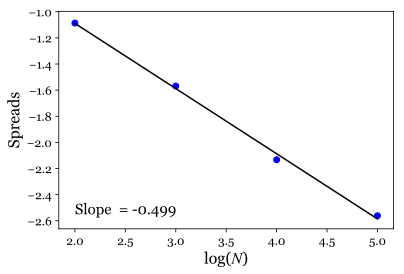

In [12]:
sample_sizes = np.array([10**2, 10**3, 10**4, 10**5]) # number of samples N to try out
trials_per_size = 100 # number of MC trials for each sample size

estimates = []
for N in sample_sizes:
    
    estimates.append([])
    for i in range(trials_per_size):
        
        x_samples = np.random.normal(loc = 1, size = N)
        estimate = np.sum(np.exp(-(0.1*x_samples**4 - 0.1*x_samples**3 - 0.5*x_samples**2)))/N

        estimates[-1].append(estimate)

stdevs = np.var(np.array(estimates), axis = 1)**0.5
plt.scatter(np.log10(sample_sizes), np.log10(stdevs), marker = 'o', color = 'blue')
beautify_plot({"title": "",
               "x":"log($N$)", "y":"Spreads"})
slope, intercept = stats.linregress(np.log10(sample_sizes), np.log10(stdevs))[:2]
plt.plot(np.linspace(2, 5, 100), slope*np.linspace(2, 5, 100) + intercept, color = 'black')
plt.text(2, -2.55, s = 'Slope  = {}'.format(slope.round(3)), fontsize = 15)
plt.show()

Again, the slope of the log-log plot is close to $-0.5$! Could this $\propto N^{-0.5}$ property of the statistical error be a general feature of these MC methods? It turns out this feature is due to the fact that variance of the mean of $N$ independent, identically distributed variables $x_1, x_2, ..., x_N$ goes as $N^{-0.5}$ for large $N$. We provide a proof of this for those interested.



<details>
<summary>Proof of the $N^{-0.5}$ dependence</summary>
<div>
    
Consider $N$ independent, identically distributed variables $x_1, x_2, ..., x_N$ each drawn from a distribution with mean $\bar{x}$ and variance $\sigma^2$, and denote their mean as $X$:
    
\begin{align}
\text{Var}(X) &= \mathbb{E}\big[X^2\big] - \mathbb{E}\big[X\big]^2\\
~\\
&= \mathbb{E}\Bigg[\bigg[ \frac{1}{N}\sum_{n = 1}^N x_n \bigg]^2\Bigg] - \mathbb{E}\Bigg[ \frac{1}{N}\sum_{n = 1}^N x_n \Bigg]^2\\
~\\
&= \frac{1}{N^2}\bigg[\mathbb{E}\bigg[\bigg[ \sum_{n = 1}^N x_n \bigg]^2\bigg] - \mathbb{E}\bigg[ \sum_{n = 1}^N x_n \bigg]^2 \bigg]\\
~\\
&= \frac{1}{N^2}\bigg[\mathbb{E}\bigg[\sum_{n = 1}^N \sum_{m = 1}^N x_n x_m \bigg] - N^2\bar{x}^2 \bigg]\\
~\\
&= \frac{1}{N^2}\bigg[\mathbb{E}\bigg[\sum_{n = 1}^N x_n^2 + \sum_{n \neq m} x_n x_m \bigg] - N^2\bar{x}^2 \bigg]\\
~\\
&= \frac{1}{N^2}\bigg[N\mathbb{E}\big[x^2 \big] + N(N - 1)\mathbb{E}[x]^2 - N^2\bar{x}^2 \bigg]\\
~\\
&= \frac{1}{N^2}\bigg[N\mathbb{E}\big[x^2 \big] - N\mathbb{E}[x]^2 \bigg]\\
~\\
&= \frac{1}{N}\text{Var(x)}\\
\end{align}

Therefore, the standard deviation of $X$, i.e. the mean of the samples $x_1, x_2, ..., x_N$ has a statistical error which goes as $N^{-0.5}$.

</div>
</details>